In [ ]:
"import pandas as pd\n",
    "\n",
    "# Read the CSV file\n",
    "df = pd.read_csv('../raw_data/Conrad - Torquay.csv')\n",
    "\n",
    "# Convert deliveryStart to datetime\n",
    "df['deliveryStart'] = pd.to_datetime(df['deliveryStart'])\n",

# Clean up the column name - remove extra spaces and ensure single column
df.columns = df.columns.str.strip()
if 'EFA block of the day ' in df.columns:
    df = df.rename(columns={'EFA block of the day ': 'EFA block of the day'})

# Fill missing delivery dates and EFA blocks
for index, row in df.iterrows():
    if pd.isna(row['Delivery date']) or pd.isna(row['EFA block of the day']):
        start_time = row['deliveryStart']
        hour = start_time.hour
        
        # EFA blocks: 
        # Block 1: 23:00-03:00 (delivery date is next day)
        # Block 2: 03:00-07:00 (delivery date is same day as 03:00)
        # Block 3: 07:00-11:00 (delivery date is same day)
        # Block 4: 11:00-15:00 (delivery date is same day)
        # Block 5: 15:00-19:00 (delivery date is same day)
        # Block 6: 19:00-23:00 (delivery date is same day)
        
        if hour >= 23:  # 23:00-23:59
            efa_block = 1
            delivery_date = (start_time + pd.Timedelta(days=1)).strftime('%d/%m/%Y')
        elif hour < 3:  # 00:00-02:59
            efa_block = 1
            delivery_date = start_time.strftime('%d/%m/%Y')
        elif hour < 7:  # 03:00-06:59
            efa_block = 2
            delivery_date = start_time.strftime('%d/%m/%Y')
        elif hour < 11:  # 07:00-10:59
            efa_block = 3
            delivery_date = start_time.strftime('%d/%m/%Y')
        elif hour < 15:  # 11:00-14:59
            efa_block = 4
            delivery_date = start_time.strftime('%d/%m/%Y')
        elif hour < 19:  # 15:00-18:59
            efa_block = 5
            delivery_date = start_time.strftime('%d/%m/%Y')
        else:  # 19:00-22:59
            efa_block = 6
            delivery_date = start_time.strftime('%d/%m/%Y')
        
        # Update missing values
        if pd.isna(row['Delivery date']):
            df.at[index, 'Delivery date'] = delivery_date
        if pd.isna(row['EFA block of the day']):
            df.at[index, 'EFA block of the day'] = efa_block

# Save updated file
df.to_csv('Conrad - Torquay_updated.csv', index=False)
print("File updated successfully!")
print(f"Total rows processed: {len(df)}")
print(f"Unique EFA blocks: {sorted(df['EFA block of the day'].unique())}")

File updated successfully!
Total rows processed: 1298
Unique EFA blocks: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]


/var/folders/hh/yly126sx0nv7wh7rwnh8n_pm0000gn/T/ipykernel_79154/1604290030.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25/12/2024' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'Delivery date'] = delivery_date


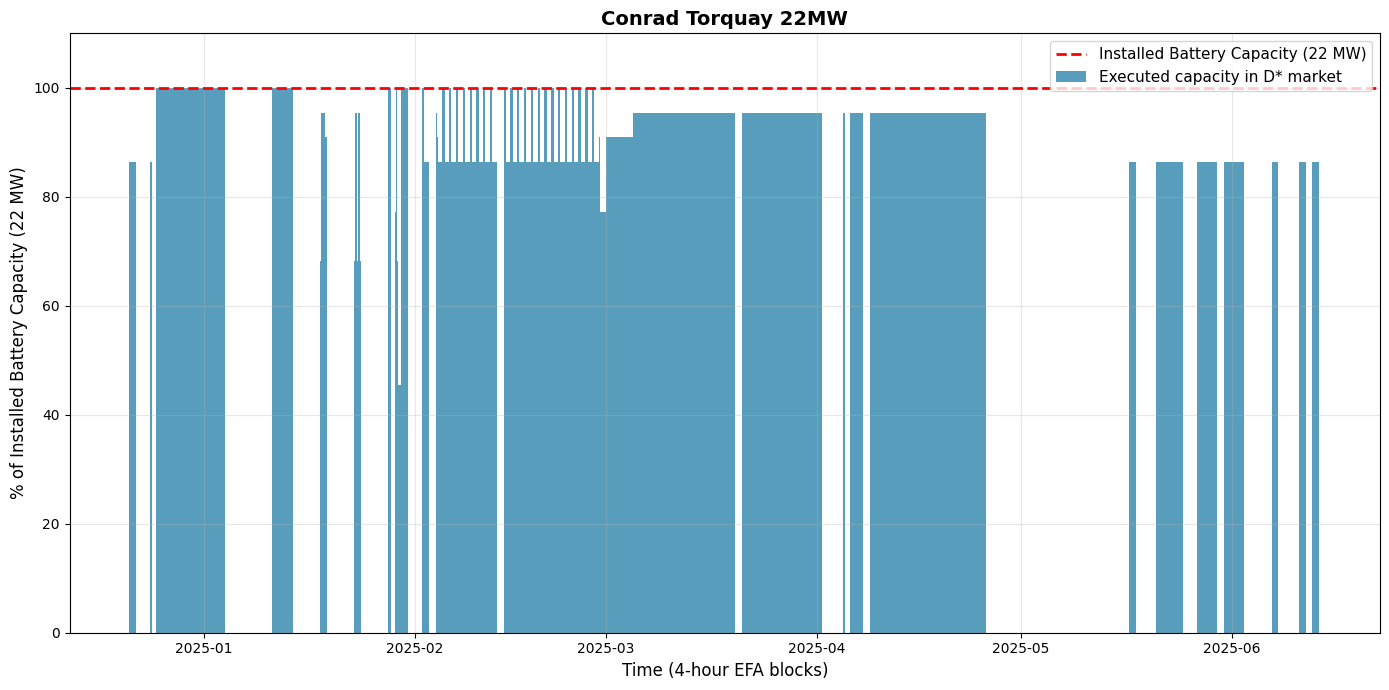

Average utilization (EFA block level): 84.4%
Peak utilization: 100.0% on 25 December 2024 EFA block 1
Total EFA blocks analyzed: 714
EFA blocks with Response products: 648
EFA blocks with no Response products: 66


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Configuration - UPDATE THIS VALUE FOR DIFFERENT SITES
INSTALLED_CAPACITY_MW = 22  # Change this value for different battery sites

# Read the updated CSV file
df = pd.read_csv('Conrad - Torquay_updated.csv')

# Convert dates
df['deliveryStart'] = pd.to_datetime(df['deliveryStart'])
df['delivery_date'] = pd.to_datetime(df['Delivery date'], format='%d/%m/%Y')

# Create a complete grid of all delivery dates and EFA blocks (1-6)
all_dates = df['delivery_date'].unique()
all_efa_blocks = [1, 2, 3, 4, 5, 6]
complete_grid = pd.MultiIndex.from_product([all_dates, all_efa_blocks], 
                                          names=['delivery_date', 'EFA block of the day']).to_frame(index=False)

# Filter for Response markets only
response_df = df[df['serviceType'] == 'Response'].copy()

# For each EFA block, find the product with the highest delivery capacity
if len(response_df) > 0:
    efa_utilization = response_df.loc[response_df.groupby(['delivery_date', 'EFA block of the day'])['Delivery capacity (MW)'].idxmax()]
    efa_utilization = efa_utilization[['delivery_date', 'EFA block of the day', 'auctionProduct', 'Delivery capacity (MW)']].reset_index(drop=True)
    efa_utilization['utilization_percentage'] = (efa_utilization['Delivery capacity (MW)'] / INSTALLED_CAPACITY_MW) * 100
else:
    efa_utilization = pd.DataFrame(columns=['delivery_date', 'EFA block of the day', 'auctionProduct', 'Delivery capacity (MW)', 'utilization_percentage'])

# Merge with complete grid to include missing EFA blocks as 0% utilization
complete_utilization = complete_grid.merge(efa_utilization, on=['delivery_date', 'EFA block of the day'], how='left')
complete_utilization['utilization_percentage'] = complete_utilization['utilization_percentage'].fillna(0)

# Create a datetime index for each EFA block for plotting
complete_utilization['efa_datetime'] = complete_utilization['delivery_date'] + pd.to_timedelta((complete_utilization['EFA block of the day'] - 1) * 4, unit='h')

# Sort by the datetime index
complete_utilization = complete_utilization.sort_values('efa_datetime')

# Calculate moving average on EFA block level (42 blocks = 7 days * 6 blocks)
efa_moving_avg = complete_utilization['utilization_percentage'].rolling(window=42, center=True).mean()

# Find highest and lowest utilization points
max_util = complete_utilization['utilization_percentage'].max()
min_util = complete_utilization['utilization_percentage'].min()
max_idx = complete_utilization['utilization_percentage'].idxmax()
min_idx = complete_utilization['utilization_percentage'].idxmin()
max_date = complete_utilization.loc[max_idx, 'efa_datetime']
min_date = complete_utilization.loc[min_idx, 'efa_datetime']

# Plot with EFA block granularity
plt.figure(figsize=(14, 7))

# Use bar plot instead of fill_between for consistent color
width = pd.Timedelta(hours=4)  # Each EFA block is 4 hours
plt.bar(complete_utilization['efa_datetime'], complete_utilization['utilization_percentage'], 
        width=width, alpha=0.8, color='#2E86AB', label='Executed capacity in D* market', 
        align='edge')

plt.axhline(100, color='red', linestyle='--', linewidth=2, label=f'Installed Battery Capacity ({INSTALLED_CAPACITY_MW} MW)')
plt.xlabel('Time (4-hour EFA blocks)', fontsize=12)
plt.ylabel(f'% of Installed Battery Capacity ({INSTALLED_CAPACITY_MW} MW)', fontsize=12)
plt.title('Conrad Torquay 22MW', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 110)
plt.tight_layout()
plt.show()

# Summary stats at EFA block level
print(f"Average utilization (EFA block level): {complete_utilization['utilization_percentage'].mean():.1f}%")
print(f"Peak utilization: {max_util:.1f}% on {max_date.strftime('%d %B %Y')} EFA block {complete_utilization.loc[max_idx, 'EFA block of the day']:.0f}")
print(f"Total EFA blocks analyzed: {len(complete_utilization)}")
print(f"EFA blocks with Response products: {(complete_utilization['utilization_percentage'] > 0).sum()}")
print(f"EFA blocks with no Response products: {(complete_utilization['utilization_percentage'] == 0).sum()}")